<a href="https://colab.research.google.com/github/AntonYermilov/sound-visualization/blob/autoencoder/multitask_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install tensorboardX

     |████████████████████████████████| 194kB 2.9MB/s 


In [0]:
import argparse
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from tensorboardX import SummaryWriter
from torchvision.datasets import MNIST

In [0]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [0]:
@torch.no_grad()
def calc_accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [0]:
class Autoencoder(nn.Module):
    def __init__(self, input_size=784, hidden_size=32, num_class=10):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_class = num_class

        self.encoder = nn.Linear(self.input_size, self.hidden_size)
        #self.encoder_mu = nn.Linear(self.hidden_size, 20)
        #self.encoder_logvar = nn.Linear(self.hidden_size, 20)

        self.decoder = nn.Linear(hidden_size, self.input_size)
        self.classifier = nn.Linear(hidden_size, self.num_class)

    def forward(self, x):
        # получаем два векторных представления
        hidden_state = F.relu(self.encoder(x.flatten(start_dim=1)))
        
        # склеили в один вектор
        #z = self.reparameterize(mu, logvar)

        logits = self.classifier(hidden_state)

        reconstruction = self.decode(hidden_state)
        reconstruction = reconstruction.view_as(x)

        return logits, reconstruction #, mu, logvar

    # берем картинку и переводим ее в вектор размера hidden_size
    # полученный вектор переводим в вектор размера 20 двумя моделями
    # первая модель для восстановления картинка
    # вторая модель для определения тональности
    def encode(self, x):
        h = F.relu(self.encoder(x.flatten(start_dim=1)))
        return self.encoder_mu(h), self.encoder_logvar(h)
    
    def reparameterize(self, mu, logvar):
        std = F.softplus(logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder(z)
        return torch.sigmoid(h)

    def classify(self, z):
        return self.classifier(z)


In [0]:
class Flatten(nn.Module):
    def forward(self, x: torch.Tensor):
        return x.flatten(start_dim=1)

In [0]:
class FlattenDecoder(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
    def forward(self, x: torch.Tensor):
        return x.view(-1, self.hidden_size, 7, 7)

In [0]:
class ConvAutoencoder(nn.Module):
    def __init__(self, hidden_size, num_class):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_class = num_class

        self.encoder = nn.Sequential(
            nn.Conv2d(1, self.hidden_size // 2, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(self.hidden_size // 2, self.hidden_size, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            #nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(0.07),
            Flatten(),
            nn.Linear(self.hidden_size * 7 * 7, self.hidden_size),
            nn.Tanh()
        )

        
        #self.encoder1 = nn.Conv2d(1, self.hidden_size // 2, kernel_size=3, stride=2, padding=1) # out: (16, 14, 14)
        #self.encoder2 = nn.Conv2d(self.hidden_size // 2, self.hidden_size, kernel_size=3, stride=2, padding=1) # out: (32, 7, 7)
        #self.encoder_mu = nn.Linear(self.hidden_size * 7 * 7, self.hidden_size)
        #self.encoder_logvar = nn.Linear(self.hidden_size * 7 * 7, self.hidden_size)
        #self.encoder3 = nn.Linear(self.hidden_size * 7 * 7, self.hidden_size)

        self.decoder = nn.Sequential(
            nn.Linear(self.hidden_size, self.hidden_size * 7 * 7),
            FlattenDecoder(self.hidden_size),
            nn.ReLU(),
            nn.ConvTranspose2d(self.hidden_size, self.hidden_size // 2, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(self.hidden_size // 2, 1, kernel_size=4, stride=2, padding=1)
        )

        #self.decoder0 = nn.Linear(self.hidden_size, self.hidden_size * 7 * 7)
        #self.decoder1 = nn.ConvTranspose2d(self.hidden_size, self.hidden_size // 2, kernel_size=4, stride=2, padding=1) # out: (16, 14, 14)
        #self.decoder2 = nn.ConvTranspose2d(self.hidden_size // 2, 1, kernel_size=4, stride=2, padding=1) # out: (1, 28, 28)
        
        self.classifier = nn.Sequential(
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.num_class)
        )

    def forward(self, x):
        #h = F.relu(self.encoder1(x))
        #h = F.relu(self.encoder2(h))
        #h = h.flatten(start_dim=1)
        #z = self.encoder3(h)
        z = self.encoder(x)
        #mu, logvar = self.encode(x)
        #z = self.reparameterize(mu, logvar)

        logits = self.classifier(z)
        reconstruction = self.decode(z)

        return logits, reconstruction #, mu, logvar

    def encode(self, x):
        #h = F.relu(self.encoder1(x))
        #h = F.relu(self.encoder2(h))
        #h = h.flatten(start_dim=1)
        return self.encoder(x)

    def decode(self, z):
        #h = F.relu(self.decoder0(z).view(-1, self.hidden_size, 7, 7))
        #h = F.relu(self.decoder1(h))
        #h = self.decoder2(h)
        return torch.sigmoid(self.decoder(z))

    def classify(self, z):
        return self.classifier(z)

In [0]:
def visualize(inputs, outputs, writer, train=True, step=0):
    inputs_grid = torchvision.utils.make_grid(inputs)
    outputs_grid = torchvision.utils.make_grid(outputs)

    writer.add_image('{}/input'.format('train' if train else 'val'), inputs_grid, step)
    writer.add_image('{}/output'.format('train' if train else 'val'), outputs_grid, step)

In [0]:
def train(loader, model, optimizer, criterion, writer, epoch):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    classification_losses = AverageMeter()
    reconstruction_losses = AverageMeter()
    kldivergence_losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    model.train()

    total_iter = len(loader)
    end = time.time()
    for i, (inputs, targets) in enumerate(loader):
        logits, reconstruction = model(inputs)

        classification_criterion, reconstruction_criterion = criterion
        classification_loss = classification_criterion(logits, targets)
        reconstruction_loss = reconstruction_criterion(reconstruction, inputs)
        #kldivergence_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        total_loss = classification_loss + reconstruction_loss #+ kldivergence_loss

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # measure accuracy and record loss
        batch_size = inputs.size(0)
        prec1, prec5 = calc_accuracy(logits, targets, topk=(1, 5))
        losses.update(total_loss.item(), batch_size)
        classification_losses.update(classification_loss.item(), batch_size)
        reconstruction_losses.update(reconstruction_loss.item(), batch_size)
        #kldivergence_losses.update(kldivergence_loss.item(), batch_size)
        top1.update(prec1[0], batch_size)
        top5.update(prec5[0], batch_size)

        global_step = (epoch * total_iter) + i + 1
        writer.add_scalar('train/loss/total', losses.val, global_step)
        writer.add_scalar('train/loss/cross-entropy', classification_losses.val, global_step)
        writer.add_scalar('train/loss/mse', reconstruction_losses.val, global_step)
        #writer.add_scalar('train/loss/kld', kldivergence_losses.val, global_step)

        writer.add_scalar('train/accuracy/top1', top1.val, global_step)
        writer.add_scalar('train/accuracy/top5', top5.val, global_step)

        if i % 50 == 0:
            print('Epoch {0} [{1}/{2}]\t'
                'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                'C Loss {closs.val:.4f} ({closs.avg:.4f})\t'
                'R Loss {rloss.val:.4f} ({rloss.avg:.4f})\t'
                'Prec@1 {top1.val:.3f} ({top1.avg:.3f})\t'
                'Prec@5 {top5.val:.3f} ({top5.avg:.3f})'.format(
                epoch + 1, i + 1, total_iter, 
                batch_time=batch_time, data_time=data_time, loss=losses,
                closs=classification_losses, rloss=reconstruction_losses,
                top1=top1, top5=top5)
            )

            visualize(inputs, reconstruction, writer, train=True, step=global_step)

In [0]:
@torch.no_grad()
def validate(loader, model, optimizer, criterion, writer, epoch=0):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    classification_losses = AverageMeter()
    reconstruction_losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    model.eval()

    total_iter = len(loader)
    end = time.time()
    for i, (inputs, targets) in enumerate(loader):
        logits, reconstruction = model(inputs)

        classification_criterion, reconstruction_criterion = criterion
        classification_loss = classification_criterion(logits, targets)
        reconstruction_loss = reconstruction_criterion(reconstruction, inputs)
        total_loss = classification_loss + reconstruction_loss

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # measure accuracy and record loss
        batch_size = inputs.size(0)
        prec1, prec5 = calc_accuracy(logits, targets, topk=(1, 5))
        losses.update(total_loss.item(), batch_size)
        classification_losses.update(classification_loss.item(), batch_size)
        reconstruction_losses.update(reconstruction_loss.item(), batch_size)
        top1.update(prec1[0], batch_size)
        top5.update(prec5[0], batch_size)

        global_step = (epoch * total_iter) + i + 1
        writer.add_scalar('val/loss/total', losses.val, global_step)
        writer.add_scalar('val/loss/cross-entropy', classification_losses.val, global_step)
        writer.add_scalar('val/loss/mse', reconstruction_losses.val, global_step)

        writer.add_scalar('val/accuracy/top1', top1.val, global_step)
        writer.add_scalar('val/accuracy/top5', top5.val, global_step)

        if i % 200 == 0:
            #print(reconstruction.shape)
            #print(reconstruction[0].detach().numpy().shape)
            img = np.squeeze(reconstruction[0].detach().numpy())
            #print(np.squeeze(images[1]).shape)
            fig = plt.figure(figsize = (5,5)) 
            ax = fig.add_subplot(111)
            ax.imshow(img, cmap='gray')
        if i % 50 == 0:
            print('Test [{0}/{1}]\t'
                'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                'C Loss {closs.val:.4f} ({closs.avg:.4f})\t'
                'R Loss {rloss.val:.4f} ({rloss.avg:.4f})\t'
                'Prec@1 {top1.val:.3f} ({top1.avg:.3f})\t'
                'Prec@5 {top5.val:.3f} ({top5.avg:.3f})'.format(
                i + 1, total_iter, 
                batch_time=batch_time, data_time=data_time, loss=losses,
                closs=classification_losses, rloss=reconstruction_losses,
                top1=top1, top5=top5)
            )

            visualize(inputs, reconstruction, writer, train=False, step=global_step)
    print('***\t'
        'Loss {loss.avg:.4f}\t'
        'Prec@1 {top1.avg:.3f}\t'
        'Prec@5 {top5.avg:.3f}'.format(
            loss=losses, top1=top1, top5=top5
        )
    )

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 [1/938]	Time 0.051 (0.051)	Data 0.000 (0.000)	Loss 0.3677 (0.3677)	C Loss 0.3677 (0.3677)	R Loss 0.2594 (0.2594)	
Epoch 1 [51/938]	Time 0.045 (0.048)	Data 0.000 (0.000)	Loss 0.4204 (0.4138)	C Loss 0.4204 (0.4138)	R Loss 0.2570 (0.2552)	
Epoch 1 [101/938]	Time 0.050 (0.047)	Data 0.000 (0.000)	Loss 0.3612 (0.4079)	C Loss 0.3612 (0.4079)	R Loss 0.2581 (0.2552)	
Epoch 1 [151/938]	Time 0.046 (0.047)	Data 0.000 (0.000)	Loss 0.3384 (0.4116)	C Loss 0.3384 (0.4116)	R Loss 0.2636 (0.2553)	
Epoch 1 [201/938]	Time 0.046 (0.047)	Data 0.000 (0.000)	Loss 0.4341 (0.4131)	C Loss 0.4341 (0.4131)	R Loss 0.2574 (0.2553)	
Epoch 1 [251/938]	Time 0.045 (0.047)	Data 0.000 (0.000)	Loss 0.3639 (0.4124)	C Loss 0.3639 (0.4124)	R Loss 0.2523 (0.2551)	
Epoch 1 [301/938]	Time 0.046 (0.047)	Data 0.000 (0.000)	Loss 0.4396 (0.4134)	C Loss 0.4396 (0.4134)	R Loss 0.2566 (0.2550)	
Epoch 1 [351/938]	Time 0.045 (0.047)	Data 0.000 (0.000)	Loss 0.4095 (0.4131)	C Loss 0.4095 (0.4131)	R Loss 0.2516 (0.2552)	
Epoch 1 [40

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test [1/157]	Time 0.024 (0.024)	Data 0.000 (0.000)	Loss 0.3858 (0.3858)	C Loss 0.3858 (0.3858)	R Loss 0.2728 (0.2728)	
Test [51/157]	Time 0.024 (0.025)	Data 0.000 (0.000)	Loss 0.4341 (0.4012)	C Loss 0.4341 (0.4012)	R Loss 0.2722 (0.2716)	
Test [101/157]	Time 0.024 (0.025)	Data 0.000 (0.000)	Loss 0.4933 (0.4131)	C Loss 0.4933 (0.4131)	R Loss 0.2684 (0.2710)	
Test [151/157]	Time 0.024 (0.025)	Data 0.000 (0.000)	Loss 0.4363 (0.4144)	C Loss 0.4363 (0.4144)	R Loss 0.2699 (0.2703)	


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 2 [1/938]	Time 0.053 (0.053)	Data 0.000 (0.000)	Loss 0.4117 (0.4117)	C Loss 0.4117 (0.4117)	R Loss 0.2566 (0.2566)	
Epoch 2 [51/938]	Time 0.049 (0.050)	Data 0.000 (0.000)	Loss 0.4436 (0.4145)	C Loss 0.4436 (0.4145)	R Loss 0.2611 (0.2556)	
Epoch 2 [101/938]	Time 0.048 (0.050)	Data 0.000 (0.000)	Loss 0.3436 (0.4187)	C Loss 0.3436 (0.4187)	R Loss 0.2575 (0.2554)	
Epoch 2 [151/938]	Time 0.048 (0.050)	Data 0.000 (0.000)	Loss 0.3701 (0.4182)	C Loss 0.3701 (0.4182)	R Loss 0.2547 (0.2554)	
Epoch 2 [201/938]	Time 0.050 (0.050)	Data 0.000 (0.000)	Loss 0.4220 (0.4164)	C Loss 0.4220 (0.4164)	R Loss 0.2546 (0.2552)	
Epoch 2 [251/938]	Time 0.052 (0.050)	Data 0.000 (0.000)	Loss 0.3875 (0.4160)	C Loss 0.3875 (0.4160)	R Loss 0.2561 (0.2554)	
Epoch 2 [301/938]	Time 0.049 (0.050)	Data 0.000 (0.000)	Loss 0.4331 (0.4141)	C Loss 0.4331 (0.4141)	R Loss 0.2490 (0.2553)	
Epoch 2 [351/938]	Time 0.050 (0.050)	Data 0.000 (0.000)	Loss 0.3426 (0.4151)	C Loss 0.3426 (0.4151)	R Loss 0.2586 (0.2553)	
Epoch 2 [40

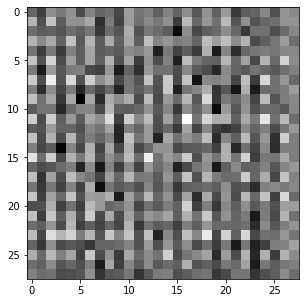

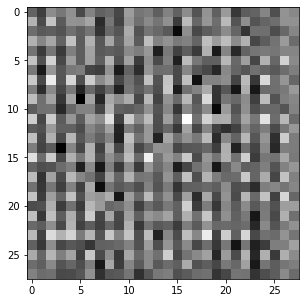

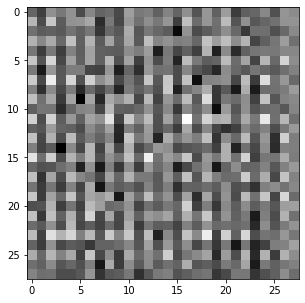

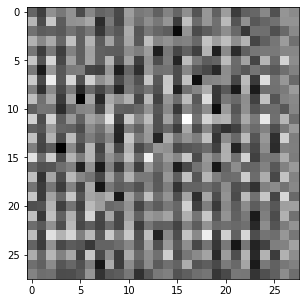

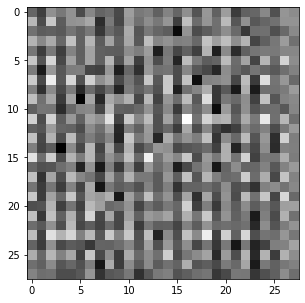

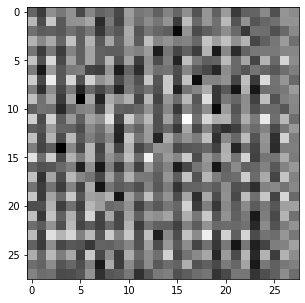

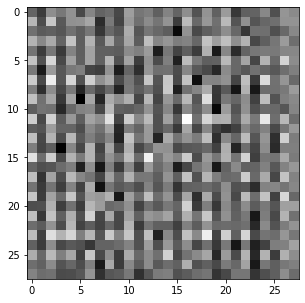

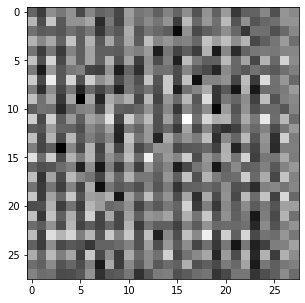

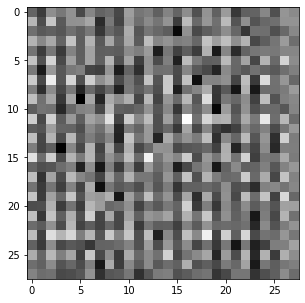

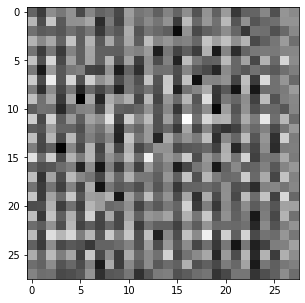

In [0]:
max_epoch = 10
batch_size = 64
learning_rate = 1e-3
summary_name = './runs/{}'.format("res")

writer = SummaryWriter(log_dir=summary_name, comment='epoch={} batch={} lr={}'.format(max_epoch, batch_size, learning_rate))

transform_train = torchvision.transforms.Compose([
    torchvision.transforms.RandomAffine(45, translate=(0.1, 0.1), scale=(0.5, 2.0)),
    torchvision.transforms.ToTensor()
])

transform_val = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

trainset = MNIST('./data/mnist', train=True, transform=transform_train, download=True)
testset = MNIST('./data/mnist', train=False, transform=transform_val)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

#model = Autoencoder(784, 128, 10)
model = ConvAutoencoder(64, 10)
# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=True)
# optimizer = optim.Adadelta(model.parameters(), lr=learning_rate)

reconstruction_criterion = nn.MSELoss()
classification_criterion = nn.CrossEntropyLoss()

criterion = (classification_criterion, reconstruction_criterion)

for epoch in range(max_epoch):
    train(train_loader, model, optimizer, criterion, writer, epoch)
    validate(test_loader, model, optimizer, criterion, writer, epoch)

torch.Size([64, 1, 28, 28])
torch.Size([64, 64])


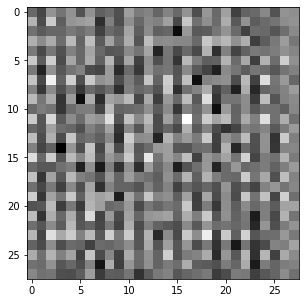

In [0]:
for (x, y) in test_loader:
    print(x.shape)
    #x = x + torch.abs(torch.randn(64, 1, 28, 28))
    #logits, reconstruction = model(x)
    t = model.encode(x)
    #t = t + 2 * torch.randn(64, 64)
    t1 = (t[0] + t[2])# / 2
    print(t.shape)
    reconstruction = model.decode(t1)
    #reconstruction = reconstruction# + torch.randn(64, 1, 28, 28) / 5
    img = np.squeeze(reconstruction[0].detach().numpy())
    fig = plt.figure(figsize = (5,5)) 
    ax = fig.add_subplot(111)
    ax.imshow(img, cmap='gray')
    break
    

In [0]:
t = F.tanh(torch.randn(10,64))
a, b = model.classifier(t), model.decoder(t)
a, b = model(testset[0])
img = np.squeeze(b.detach().numpy())
#print(np.squeeze(images[1]).shape)
fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
for ai, bi in zip(a, b):
  img = np.squeeze(bi.detach().numpy())
  #print(np.squeeze(images[1]).shape)
  print(torch.argmax(ai)) 
  fig = plt.figure(figsize = (5,5)) 
  ax = fig.add_subplot(111)
  ax.imshow(img, cmap='gray')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


TypeError: ignored